# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

## Prepare the data

In [1]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda")

In [2]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
!mkdir celeba

In [4]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    download=True,
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    download=True,
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Files already downloaded and verified


In [5]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [34]:
#!L
BATCH_SIZE = 64

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, drop_last=True)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [ ]:
#!L
dimZ = 100  # Considering face reconstruction task, which size of representation seems reasonable?
dim_input = 64
# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics


class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()

        # TODO

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_input * dim_input, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, dimZ),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, dim_input * dim_input),
            nn.Sigmoid()
        )

    def forward(self, x):

        # TODO

        latent_code = self.encoder(x)
        reconstruction = torch.reshape(self.decoder(latent_code), (x.shape[0], dim_input, dim_input))

        return reconstruction, latent_code

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
        #print("inited module {}".format(m))
    else:
        #print("skipping init for module {}".format(m))
        pass


In [ ]:
#!L

# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)



# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [ ]:
autoencoder.train(False)
for (X, _) in train_loader:
    optimizer.zero_grad()
    (reconstruction, latent) = autoencoder(X.to(device))
    break

reconstruction = reconstruction.cpu().data.numpy()
print(X.shape)
print(reconstruction.shape)

torch.Size([64, 1, 64, 64])
(64, 64, 64)


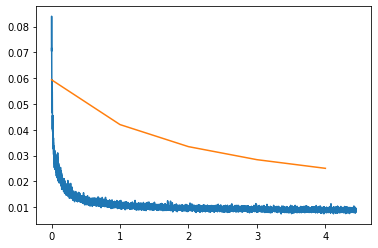

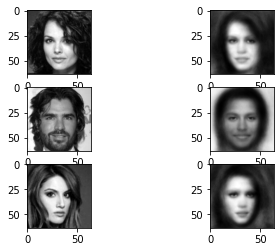

In [ ]:
N = 3

plt.plot(number_train_losses(train_losses), train_losses, label='train')
plt.plot(list(range(len(val_losses))), val_losses, label='val')

fig, axs = plt.subplots(nrows=N, ncols=2)

images, samples = get_reconstructions(autoencoder, N)

for i in range(N):
    axs[i, 0].imshow(images[i], cmap='gray')
    axs[i, 1].imshow(samples[i], cmap='gray')

In [ ]:
autoencoder.apply(init_weights)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=4096, bias=True)
    (3): Sigmoid()
  )
)

validation: 100%|██████████| 311/311 [00:23<00:00, 13.00it/s]


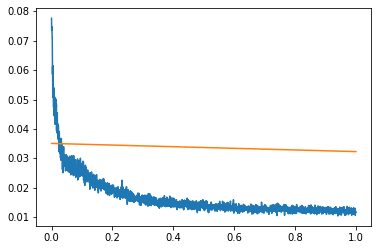

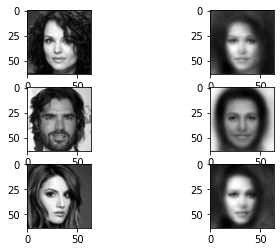

validation: 100%|██████████| 311/311 [00:23<00:00, 13.11it/s]


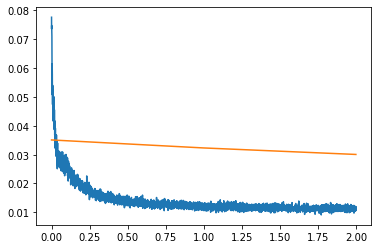

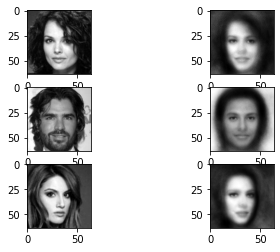

validation: 100%|██████████| 311/311 [00:24<00:00, 12.96it/s]


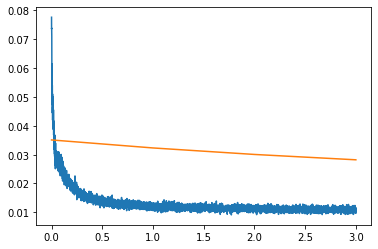

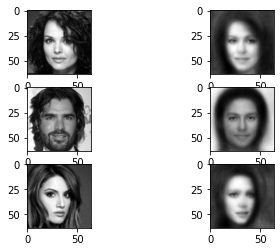

validation: 100%|██████████| 311/311 [00:24<00:00, 12.94it/s]


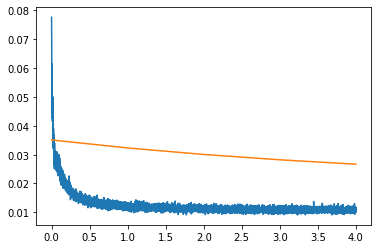

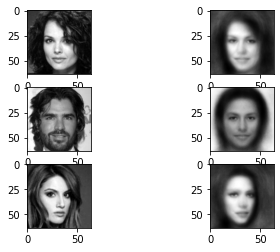

validation: 100%|██████████| 311/311 [00:24<00:00, 12.92it/s]


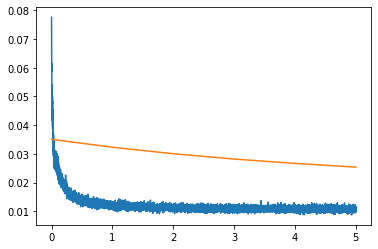

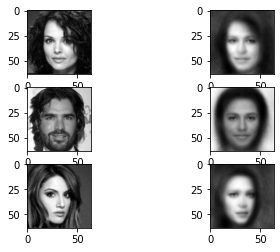

validation: 100%|██████████| 311/311 [00:23<00:00, 13.16it/s]


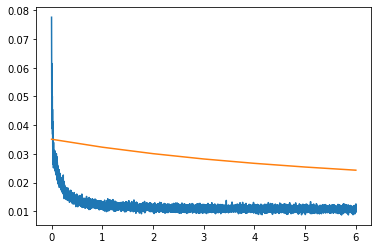

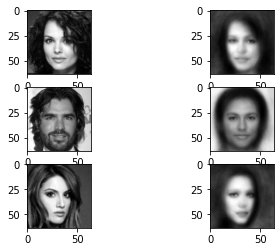

validation: 100%|██████████| 311/311 [00:23<00:00, 13.02it/s]


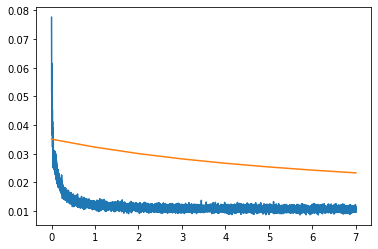

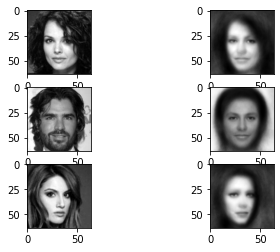

validation: 100%|██████████| 311/311 [00:23<00:00, 12.97it/s]


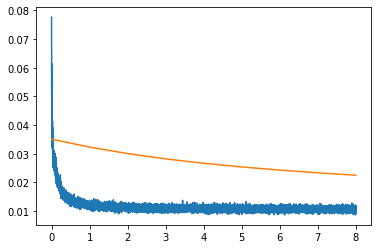

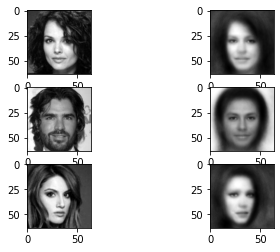

validation: 100%|██████████| 311/311 [00:24<00:00, 12.84it/s]


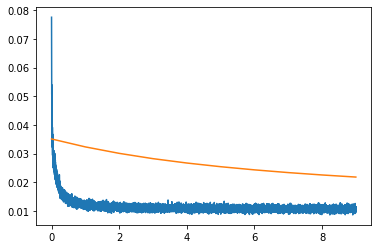

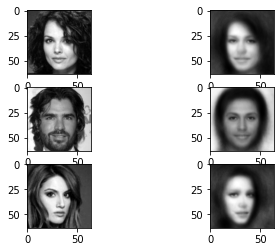

validation: 100%|██████████| 311/311 [00:23<00:00, 12.96it/s]


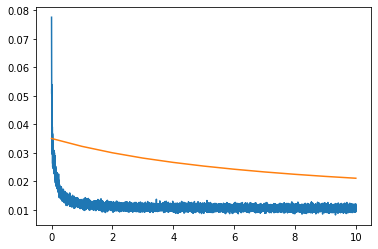

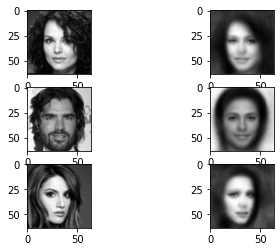

<Figure size 432x288 with 0 Axes>

In [ ]:
#!L
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

from itertools import islice
from tqdm import tqdm

def get_reconstructions(model, n):
    images, _ = list(islice(val_loader, 1))[0]
    reconstruction, latent_code = model(images.to(device))
    return torch.squeeze(images[:n]).data, reconstruction[:n].cpu().data


def number_train_losses(losses):
    result = []
    for i, loss in enumerate(losses):
        result.append(i / (len(train_dataset) / BATCH_SIZE))
    return result

def calc_val_losses(model, loader, stop_after=None):
    epoch_val_losses = []
    for (X, _) in tqdm(loader, desc="validation"):
        (reconstruction, latent) = model(torch.squeeze(X).to(device))
        loss = criterion(reconstruction, torch.squeeze(X).to(device))
        epoch_val_losses.append(loss.cpu().data.numpy())
        if stop_after is not None and len(epoch_val_losses) > stop_after:
            break
    return np.mean(epoch_val_losses)

epoch_n = 10
show_samples = 3

train_losses = []

stop_after = None

val_losses = [calc_val_losses(autoencoder, val_loader, stop_after)]



for epoch in range(epoch_n):
    autoencoder.train(True)
    for (X, _) in tqdm(train_loader, desc="training"):
        optimizer.zero_grad()
        (reconstruction, latent) = autoencoder(torch.squeeze(X).to(device))
        loss = criterion(reconstruction, torch.squeeze(X).to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.cpu().data.numpy())
        if stop_after is not None and len(train_losses) >  stop_after:
            break
    
    autoencoder.train(False)
 
    val_losses.append(calc_val_losses(autoencoder, val_loader, stop_after))
    

    plt.plot(number_train_losses(train_losses), train_losses, label='train')
    plt.plot(list(range(len(val_losses))), val_losses, label='val')

    fig, axs = plt.subplots(nrows=show_samples, ncols=2)

    images, samples = get_reconstructions(autoencoder, show_samples)

    for i in range(show_samples):
        axs[i, 0].imshow(images[i], cmap='gray')
        axs[i, 1].imshow(samples[i], cmap='gray')
    plt.show()
    plt.clf()

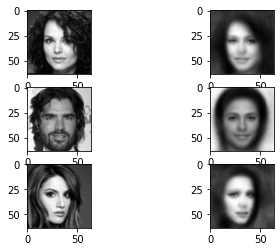

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(nrows=show_samples, ncols=2)

images, samples = get_reconstructions(autoencoder, show_samples)

for i in range(show_samples):
    axs[i, 0].imshow(images[i], cmap='gray')
    axs[i, 1].imshow(samples[i], cmap='gray')
plt.show()
plt.clf()

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

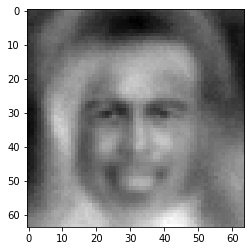

In [ ]:
#!L
z = torch.randn(25, dimZ) * 0.00
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1)


plt.imshow(torch.reshape(reconstruction[0].cpu(), (dim_input, dim_input)).data.numpy(), cmap='gray')


So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [30]:
#!L
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100
dim_input = 64
eps = 1e-5
# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST


class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        # TODO
        self.encoder_prepare = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_input * dim_input, 2 * dimZ),
            nn.ReLU()
        )
        self.z_avg = nn.Sequential(
            nn.Linear(2 * dimZ, dimZ),
            nn.ReLU()
        )
        self.z_logsigma = nn.Sequential(
            nn.Linear(2 * dimZ, dimZ),
        )
        self.decoder_prepare = nn.Sequential(
            nn.Linear(dimZ, 2 * dimZ),
            nn.ReLU(),
        )
        self.y_avg = nn.Sequential(
            nn.Linear(2 * dimZ, dim_input * dim_input),
            nn.Sigmoid()
        )
        self.y_logsigma = nn.Sequential(
            nn.Linear(2 * dimZ, dim_input * dim_input),
        )

    def gaussian_sampler(self, z_avg, logsigma):
        noise = torch.randn_like(z_avg)
        return noise * logsigma.exp() + z_avg

    def forward(self, x):
        z_params = self.encoder_prepare(x)
        z_avg = self.z_avg(z_params)
        z_logsigma = self.z_logsigma(z_params)
        z = self.gaussian_sampler(z_avg, z_logsigma)
        y_params = self.decoder_prepare(z)
        y_avg = torch.reshape(self.y_avg(y_params), (x.shape[0], dim_input, dim_input))
        y_logsigma = torch.reshape(self.y_logsigma(y_params), (x.shape[0], dim_input, dim_input))
        return y_avg, y_logsigma, z_avg, z_logsigma


vae = VAE().to(device)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=\sum_{i=1}^{dimX} (-log(\sigma_i) -\frac{(\mu_i-x)^2}{2\sigma_i^2} )$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [25]:
#!L
def KL_divergence(mu, logsigma):
    logsigma_sq = 2 * logsigma
    return (-1/2) * (logsigma_sq.sum() - logsigma_sq.exp().sum() - torch.square(mu).sum()) 


def log_likelihood(x, mu, logsigma):
    return -logsigma.sum() - torch.div(torch.square(x - mu), (2 * logsigma).exp()).sum() / 2


def loss_vae_KL(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z)

def loss_vae_likelihood(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return log_likelihood(x, mu_gen, logsigma_gen)

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    KL = loss_vae_KL(x, mu_gen, logsigma_gen, mu_z, logsigma_z)
    #print()
    #print(logsigma_gen)
    #print("x.shape = {} mu_gen.shape = {} logsigma_gen.shape = {}".format(x.shape, mu_gen.shape, logsigma_gen.shape))
    likelihood = loss_vae_likelihood(x, mu_gen, logsigma_gen, mu_z, logsigma_z)
    #print("KL: {}\n likelihood: {}".format(KL.cpu().data.numpy(), likelihood.cpu().data.numpy()))
    return KL - likelihood

And train the model:

In [32]:

optimizer = optim.Adam(vae.parameters())

validation: 100%|██████████| 311/311 [00:25<00:00, 12.31it/s]


Validation:
    loss = 15942.017578125
    logsigma = 0.005467756185680628
    KL = 3339.8369140625
    likelihood = -12602.1806640625


validation: 100%|██████████| 311/311 [00:24<00:00, 12.73it/s]


Validation:
    loss = -417080.28125
    logsigma = -2.2095553874969482
    KL = 14716.955078125
    likelihood = 431797.25


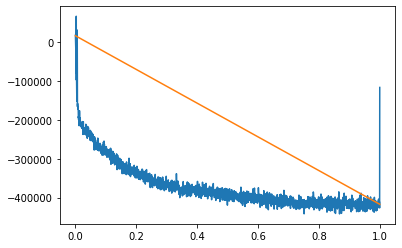

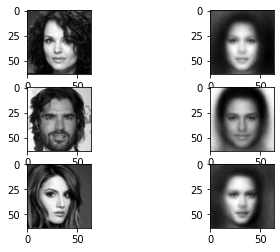

validation: 100%|██████████| 311/311 [00:24<00:00, 12.88it/s]


Validation:
    loss = -425228.375
    logsigma = -2.209639072418213
    KL = 12929.875
    likelihood = 438158.3125


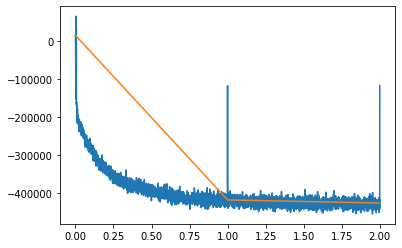

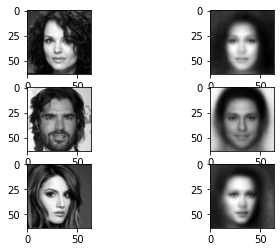

validation: 100%|██████████| 311/311 [00:25<00:00, 12.28it/s]


Validation:
    loss = -432261.59375
    logsigma = -2.170785427093506
    KL = 12467.2685546875
    likelihood = 444728.90625


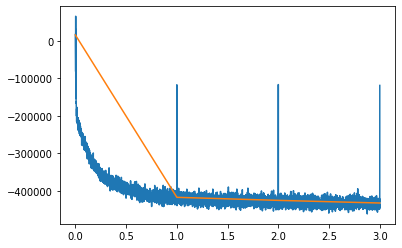

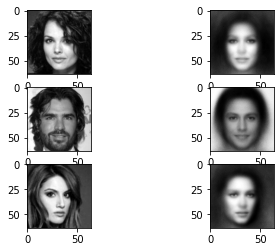

validation: 100%|██████████| 311/311 [00:24<00:00, 12.62it/s]


Validation:
    loss = -435031.9375
    logsigma = -2.2261438369750977
    KL = 12250.8447265625
    likelihood = 447282.78125


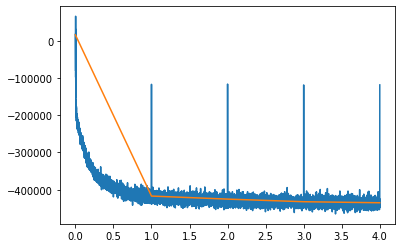

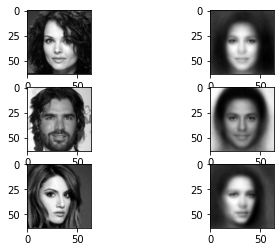

training:   7%|▋         | 188/2544 [00:15<03:19, 11.79it/s]


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [33]:
#!L
# train your variational autoencoder
# visualize progress in reconstruction and loss decay


from itertools import islice
from tqdm import tqdm


def get_reconstructions(model, n):
    images, _ = list(islice(val_loader, 1))[0]
    result, _, _, _ = model(images.to(device))
    return torch.squeeze(images[:n]).data, result[:n].cpu().clamp(0, 1).data

def number_train_losses(losses):
    result = []
    for i, loss in enumerate(losses):
        result.append(i / (len(train_dataset) / BATCH_SIZE))
    return result

def calc_val_losses(model, loader, stop_after=None):
    epoch_val_losses = []
    logsigma_lst = []
    KL_lst = []
    likelihood_lst = []
    model.train(False)
    for (X, _) in tqdm(loader, desc="validation"):
        X_s = torch.squeeze(X).to(device)
        result = model(X_s)
        KL = loss_vae_KL(X_s, *result)
        likelihood = loss_vae_likelihood(X_s, *result)
        loss = KL - likelihood
        epoch_val_losses.append(loss.cpu().data.numpy())
        logsigma_lst.append(np.mean(result[1].cpu().data.numpy()))
        KL_lst.append(KL.cpu().data.numpy())
        likelihood_lst.append(likelihood.cpu().data.numpy())
        if stop_after is not None and len(epoch_val_losses) > stop_after:
            break
    print("Validation:")
    print("    loss = {}".format(np.mean(epoch_val_losses)))
    print("    logsigma = {}".format(np.mean(logsigma_lst)))
    print("    KL = {}".format(np.mean(KL_lst)))
    print("    likelihood = {}".format(np.mean(likelihood_lst)))
    return np.mean(epoch_val_losses)



epoch_n = 10
show_samples = 3

train_losses = []

stop_after = None

val_losses = [calc_val_losses(vae, val_loader, stop_after)]



for epoch in range(epoch_n):
    vae.train(True)
    for (X, _) in tqdm(train_loader, desc="training"):
        optimizer.zero_grad()
        X_s = torch.squeeze(X).to(device)
        result = vae(X_s)
        loss = loss_vae(X_s, *result)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.cpu().data.numpy())
        if stop_after is not None and len(train_losses) >  stop_after:
            break
    
    vae.train(False)
 
    val_losses.append(calc_val_losses(vae, val_loader, stop_after))
    

    plt.plot(number_train_losses(train_losses), train_losses, label='train')
    plt.plot(list(range(len(val_losses))), val_losses, label='val')

    fig, axs = plt.subplots(nrows=show_samples, ncols=2)

    images, samples = get_reconstructions(vae, show_samples)

    for i in range(show_samples):
        axs[i, 0].imshow(images[i], cmap='gray')
        axs[i, 1].imshow(samples[i], cmap='gray')
    plt.show()
    plt.clf()



And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=\sum_{i=1}^{dimX} (-log(\sigma_i) -\frac{(\mu_i-x)^2}{2\sigma_i^2} )$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [110]:
PI = torch.tensor(torch.acos(torch.zeros(1)).item() * 2)

def test_log_like(x, mu, logsigma):
    pi_sum = -torch.log(2 * PI) * x.numel() / 2
    sigma_sum = - logsigma.sum()
    diff_sq = torch.square(x - mu)
    sigma_sq = (2 * logsigma).exp()
    div = -torch.div(diff_sq, sigma_sq) / 2
    #return  pi_sum + sigma_sum + div.sum()
    return  div.sum()

#def brute(x, mu, logsigma):



def test_vae_like(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return test_log_like(x, mu_gen, logsigma_gen)

In [113]:
image = images.to(device)[:1,]
image.shape

torch.Size([1, 1, 64, 64])

In [114]:
result = vae(image)
mu_gen, logsigma_gen, mu_z, logsigma_z = result

In [73]:
delta = torch.square(images[0].to(device) - mu_gen[0])
sq = (2 * logsigma_gen[0]).exp()
torch.div(delta, sq)

tensor([[[1.1778e-01, 9.6773e-02, 1.0743e-01,  ..., 1.2235e-02,
          2.8087e-02, 3.9407e-02],
         [1.0623e-01, 9.6524e-02, 8.1852e-02,  ..., 1.5846e-03,
          2.4888e-02, 2.9025e-02],
         [8.0998e-02, 7.1809e-02, 6.8003e-02,  ..., 5.3392e-02,
          6.4084e-05, 2.0387e-03],
         ...,
         [1.0301e+00, 9.8099e-01, 1.2674e+00,  ..., 8.6664e-02,
          1.7442e-04, 4.3992e-06],
         [7.3002e-01, 5.8310e-01, 5.9096e-01,  ..., 7.1216e-02,
          1.8619e-03, 1.3288e-01],
         [4.7336e-02, 2.0570e-01, 4.2317e-01,  ..., 1.0526e-01,
          6.1799e-02, 7.4294e-02]]], device='cuda:0', grad_fn=<DivBackward0>)

In [115]:
test_vae_like(image.to(device)[:1, :1], *result)

tensor(-1141.1870, device='cuda:0', grad_fn=<SumBackward0>)

In [98]:
64 ** 3

262144

In [71]:

#axs[i, 0].imshow(images[i], cmap='gray')
#plt.imshow(images[0], cmap='gray')


In [ ]:
#!L
images, _ = list(islice(val_loader, 1))[0]
mu_gen, _, _, _ = vae(images.to(device))
reconstruction = mu_gen[:16].cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

And finally sample from VAE.

In [ ]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))



def generate(vae, n):
    z = vae.gaussian_sampler(torch.zeros(dimZ), torch.ones(dimZ))
    y_params = vae.decoder_prepare(z)
    y_avg = torch.reshape(vae.y_avg(y_params), (x.shape[0], dim_input, dim_input))
    y_logsigma = torch.reshape(vae.y_logsigma(y_params), (x.shape[0], dim_input, dim_input))
    return y_avg, y_logsigma, z_avg, z_logsigma

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## If you are going to do part 4 (presicion-recall score): 

In [ ]:
#!L
# using your model, generate face set with len = 10000
answ = <generated dataset>

## Save it ot npz

In [ ]:
#!L
np.savez("vae.npz", Pictures=answ)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="https://github.com/sdelta/Practical_DL/blob/spring21/homework03/linear.png?raw=1" alt="linear">